In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"

import keras_nlp
import keras
import tensorflow as tf

import numpy as np 
import pandas as pd
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px

In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.16.1
Keras: 3.3.3
KerasNLP: 0.15.1


In [3]:
class CFG:
    seed = 42  # Random seed
    preset = "deberta_v3_extra_small_en" # Name of pretrained models
    sequence_length = 512  # Input sequence length
    epochs = 3 # Training epochs
    batch_size = 16  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler
    label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
    name2label = {v:k for k, v in label2name.items()}
    class_labels = list(label2name.keys())
    class_names = list(label2name.values())

In [4]:
keras.utils.set_random_seed(CFG.seed)

In [5]:
keras.mixed_precision.set_global_policy("mixed_float16")

In [6]:
BASE_PATH = '/kaggle/input/llm-classification-finetuning'

# 📖 | Meta Data 

The competition dataset comprises user interactions from the ChatBot Arena. In each interaction, a judge presents one or more prompts to two different large language models and then indicates which model provided the more satisfactory response. The training data contains `55,000` rows, with an expected `25,000` rows in the test set.

## Files

### `train.csv`
- `id`: Unique identifier for each row.
- `model_[a/b]`: Model identity, present in train.csv but not in test.csv.
- `prompt`: Input prompt given to both models.
- `response_[a/b]`: Model_[a/b]'s response to the prompt.
- `winner_model_[a/b/tie]`: Binary columns indicating the judge's selection (ground truth target).

### `test.csv`
- `id`: Unique identifier for each row.
- `prompt`: Input prompt given to both models.
- `response_[a/b]`: Model_[a/b]'s response to the prompt.

> Note that each interaction may have multiple prompts and responses, but this notebook will use only **one prompt per interaction**. You can choose to use all prompts and responses. Additionally, prompts and responses in the dataframe are provided as string-formatted lists, so they need to be converted to literal lists using `eval()`.


In [7]:
# Load Train Data
df = pd.read_csv(f'{BASE_PATH}/train.csv') 

# Sample data
# df = df.sample(frac=0.10)

# Take the first prompt and its associated response
df["prompt"] = df.prompt.map(lambda x: eval(x)[0])
df["response_a"] = df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
df["response_b"] = df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Label conversion
df["class_name"] = df[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)
df["class_label"] = df.class_name.map(CFG.name2label)

# Show Sample
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,winner_model_a,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,winner_model_b,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1,winner_tie,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0,winner_model_a,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0,winner_model_b,1


In [8]:
# Load Test Data
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')

# Take the first prompt and response
test_df["prompt"] = test_df.prompt.map(lambda x: eval(x)[0])
test_df["response_a"] = test_df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
test_df["response_b"] = test_df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Show Sample
test_df.head()

,id,prompt,response_a,response_b
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...
2,1233961,How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...


In [9]:
# Define a function to create options based on the prompt and choices
def make_pairs(row):
    row["encode_fail"] = False
    try:
        prompt = row.prompt.encode("utf-8").decode("utf-8")
    except:
        prompt = ""
        row["encode_fail"] = True

    try:
        response_a = row.response_a.encode("utf-8").decode("utf-8")
    except:
        response_a = ""
        row["encode_fail"] = True

    try:
        response_b = row.response_b.encode("utf-8").decode("utf-8")
    except:
        response_b = ""
        row["encode_fail"] = True
        
    row['options'] = [f"Prompt: {prompt}\n\nResponse: {response_a}",  # Response from Model A
                      f"Prompt: {prompt}\n\nResponse: {response_b}"  # Response from Model B
                     ]
    return row


In [10]:
df = df.apply(make_pairs, axis=1)  # Apply the make_pairs function to each row in df
display(df.head(2))  # Display the first 2 rows of df

test_df = test_df.apply(make_pairs, axis=1)  # Apply the make_pairs function to each row in df
display(test_df.head(2))  # Display the first 2 rows of df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label,encode_fail,options
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,winner_model_a,0,False,[Prompt: Is it morally right to try to have a ...
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,winner_model_b,1,False,[Prompt: What is the difference between marria...


,id,prompt,response_a,response_b,encode_fail,options
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...,False,"[Prompt: I have three oranges today, I ate an ..."
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...,False,[Prompt: You are a mediator in a heated politi...


## Encoding Fail Statistics

Let's examine how many samples have encoding issues. From the code below, we can see that only $1\%$ of the samples failed to be encoded, while $99\%$ of the samples don't have any issues. A similar pattern can be expected for the test data as well. Thus, considering empty strings for this small portion of the data will not have much impact on our training and inference.

In [11]:
df.encode_fail.value_counts(normalize=False)

encode_fail
False    56885
True       592
Name: count, dtype: int64

# 🎨 | Exploratory Data Analysis (EDA)

## LLM Distribution

In [12]:
model_df = pd.concat([df.model_a, df.model_b])
counts = model_df.value_counts().reset_index()
counts.columns = ['LLM', 'Count']

# Create a bar plot with custom styling using Plotly
fig = px.bar(counts, x='LLM', y='Count',
             title='Distribution of LLMs',
             color='Count', color_continuous_scale='viridis')

fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability

fig.show()


## Winning Distribution

In [13]:
counts = df['class_name'].value_counts().reset_index()
counts.columns = ['Winner', 'Win Count']

fig = px.bar(counts, x='Winner', y='Win Count',
             title='Winner distribution for Train Data',
             labels={'Winner': 'Winner', 'Win Count': 'Win Count'},
             color='Winner', color_continuous_scale='viridis')

fig.update_layout(xaxis_title="Winner", yaxis_title="Win Count")

fig.show()


# 🔪 | Data Split

In the code snippet provided below, we will divide the existing data into training and validation using a stratification of `class_label` column.

In [14]:
from sklearn.model_selection import train_test_split  # Import package

train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["class_label"])

# 🍽️ | Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [15]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

Now, let's examine what the output shape of the preprocessing layer looks like. The output shape of the layer can be represented as $(num\_responses, sequence\_length)$.

In [16]:
outs = preprocessor(df.options.iloc[0])  # Process options for the first row

# Display the shape of each processed output
for k, v in outs.items():
    print(k, ":", v.shape)

token_ids : (2, 512)
padding_mask : (2, 512)


We'll use the `preprocessing_fn` function to transform each text option using the `dataset.map(preprocessing_fn)` method.

In [17]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# 🍚 | DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.

To learn more about `tf.data`, refer to this [documentation](https://www.tensorflow.org/guide/data).

In [18]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=True, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, keras.utils.to_categorical(labels, num_classes=3))  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=False)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

## Build Train/Valid Dataloader

In [19]:
# Train
train_texts = train_df.options.tolist()  # Extract training texts
train_labels = train_df.class_label.tolist()  # Extract training labels
train_ds = build_dataset(train_texts, train_labels,
                         batch_size=CFG.batch_size,
                         shuffle=True)

# Valid
valid_texts = valid_df.options.tolist()  # Extract validation texts
valid_labels = valid_df.class_label.tolist()  # Extract validation labels
valid_ds = build_dataset(valid_texts, valid_labels,
                         batch_size=CFG.batch_size,
                         shuffle=False)

In [20]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1.0e-6, 0.6e-6 * batch_size, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.8

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

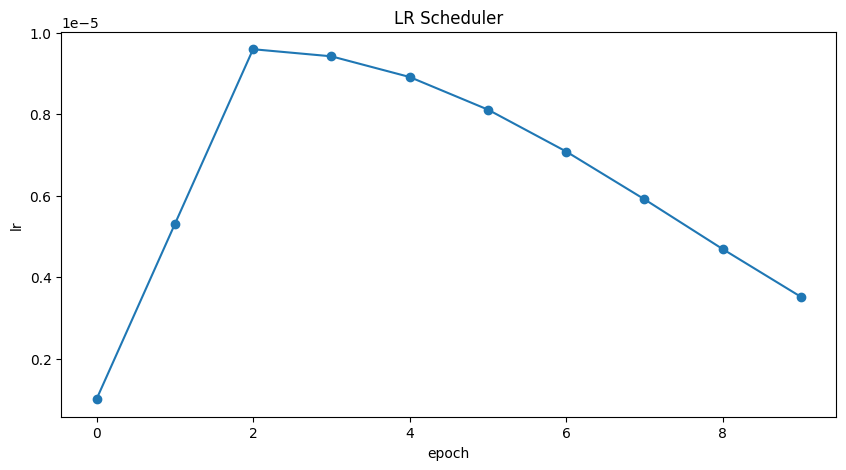

In [21]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

In [22]:
ckpt_cb = keras.callbacks.ModelCheckpoint(f'best_model.weights.h5',
                                          monitor='val_log_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min')  # Get Model checkpoint callback

In [23]:
log_loss = keras.metrics.CategoricalCrossentropy(name="log_loss")

In [24]:
# Define input layers
inputs = {
    "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),
    "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"),
}
# Create a DebertaV3Classifier backbone
backbone = keras_nlp.models.DebertaV3Backbone.from_preset(
    CFG.preset,
)

# Compute embeddings for first response: (P + R_A) using backbone
response_a = {k: v[:, 0, :] for k, v in inputs.items()}
embed_a = backbone(response_a)

# Compute embeddings for second response: (P + R_B), using the same backbone
response_b = {k: v[:, 1, :] for k, v in inputs.items()}
embed_b = backbone(response_b)

# Compute final output
embeds = keras.layers.Concatenate(axis=-1)([embed_a, embed_b])
embeds = keras.layers.GlobalAveragePooling1D()(embeds)
outputs = keras.layers.Dense(3, activation="softmax", name="classifier")(embeds)
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[
        log_loss,
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, None)      │          0 │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, None)      │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_backbone │ (None, None, 384) │ 70,682,112 │ get_item_1[0][0], │
│ (DebertaV3Backbone) │                   │            │ get_item[0][0],   │
│                     │                   │            │ get_item_3[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 768) │          0 │ deberta_v3_backb… │
│ (Concatenate)       │                   │            │ deberta_v3_backb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ concatenate[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 3)         │      2,307 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,684,419 (269.64 MB)

 Trainable params: 70,684,419 (269.64 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Currently throwing error !! [probably library or env issue, so hopefully will be fixed soon]

# keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [27]:
# Start training the model
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[lr_cb, ckpt_cb]
)

Epoch 1/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 2886s 994ms/step - accuracy: 0.3883 - log_loss: 1.1496 - loss: 1.1506 - val_accuracy: 0.4369 - val_log_loss: 1.0643 - val_loss: 1.0662 - learning_rate: 1.0000e-06
Epoch 2/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 2829s 977ms/step - accuracy: 0.4406 - log_loss: 1.0633 - loss: 1.0653 - val_accuracy: 0.4659 - val_log_loss: 1.0426 - val_loss: 1.0452 - learning_rate: 5.3000e-06
Epoch 3/3
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 2801s 975ms/step - accuracy: 0.4634 - log_loss: 1.0404 - loss: 1.0433 - val_accuracy: 0.4723 - val_log_loss: 1.0321 - val_loss: 1.0353 - learning_rate: 9.6000e-06


In [28]:
model.load_weights('/kaggle/working/best_model.weights.h5')

In [29]:
# Build test dataset
test_texts = test_df.options.tolist()
test_ds = build_dataset(test_texts,
                         batch_size=min(len(test_df), CFG.batch_size),
                         shuffle=False)

In [30]:
# Make predictions using the trained model on test data
test_preds = model.predict(test_ds, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [31]:
sub_df = test_df[["id"]].copy()
sub_df[CFG.class_names] = test_preds.tolist()
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.258545,0.245728,0.496094
1,211333,0.282715,0.324463,0.393311
2,1233961,0.172729,0.455811,0.371338


In [38]:
# ==============================================================
#  EVALUATION OF TRAINING (add this cell at the end of the notebook)
# ==============================================================

import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --------------------------------------------------------------
# 1. 검증 데이터셋(Validation Set)에 대한 예측 생성
# --------------------------------------------------------------
print("--- 검증 데이터셋에 대한 예측을 생성합니다 ---")
try:
    y_pred_probs = model.predict(valid_ds, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # 실제 정답(True labels)을 valid_df에서 가져옵니다.
    y_true = valid_df['class_label'].values
    print("예측 생성 완료.")
except NameError as e:
    print(f"오류: {e}")
    print("이 코드를 실행하기 전에 모델(model)과 검증 데이터(valid_df, valid_ds)가 정의되어 있는지 확인하세요.")
    raise e
except Exception as e:
    print(f"예상치 못한 오류 발생: {e}")
    raise e

# --------------------------------------------------------------
# 2. 정량 분석 (Quantitative Analysis)
# --------------------------------------------------------------
print("\n--- 2. 정량 분석 (Classification Report & Confusion Matrix) ---")

# 클래스 이름을 CFG 객체에서 가져옵니다.
class_names = list(CFG.label2name.values())

# (1) Classification Report (정밀도, 재현율, F1-점수)
print("\nClassification Report:")
print(metrics.classification_report(y_true, y_pred, target_names=class_names))

# (2) Confusion Matrix (혼동 행렬) 생성 및 시각화
cm = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("\nConfusion matrix(혼동 행렬)가 'confusion_matrix.png' 파일로 저장되었습니다.")
plt.show()

# --------------------------------------------------------------
# 3. 편향성 분석 (Bias Analysis) – 답변 길이 편향
# --------------------------------------------------------------
print("\n--- 3. 답변 길이(Verbosity) 편향성 분석 ---")

# 분석용 DataFrame 생성
analysis_df = valid_df.copy()
analysis_df['y_true'] = y_true
analysis_df['y_pred'] = y_pred
analysis_df['is_correct'] = (analysis_df['y_true'] == analysis_df['y_pred'])

# Response A와 B의 길이 계산
analysis_df['len_response_a'] = analysis_df['response_a'].str.len()
analysis_df['len_response_b'] = analysis_df['response_b'].str.len()

# 길이 차이 (A - B)
analysis_df['len_diff'] = analysis_df['len_response_a'] - analysis_df['len_response_b']

# 길이 차이를 구간(bin)으로 나눔
bins = [-np.inf, -100, -1, 1, 100, np.inf]
labels = [
    'B >> A (B가 훨씬 김)',
    'B > A (B가 김)',
    'A ≈ B (비슷함)',
    'A > B (A가 김)',
    'A >> B (A가 훨씬 김)'
]
analysis_df['len_diff_bin'] = pd.cut(analysis_df['len_diff'],
                                    bins=bins, labels=labels, right=False)

# 구간별 정확도 출력
print("\n답변 길이 차이에 따른 정확도 (A 길이 - B 길이):")
print(analysis_df.groupby('len_diff_bin', observed=True)['is_correct'].mean())

# --------------------------------------------------------------
# 4. 질적 분석 (Qualitative Analysis) – 오분류 샘플 검토
# --------------------------------------------------------------
print("\n--- 4. 질적 분석 (주요 오분류 샘플) ---")

# 오분류된 샘플만 필터링
misclassified_df = analysis_df[analysis_df['is_correct'] == False]

# 가장 빈번한 오류 유형 (True → Pred) 상위 5개
print("\n가장 빈번한 오류 유형 5가지 (실제값 → 예측값):")
error_counts = misclassified_df.groupby(['y_true', 'y_pred']).size().nlargest(5)

# 레이블을 이름으로 변환 (가독성 향상)
error_counts.index = error_counts.index.map(
    lambda x: (CFG.label2name[x[0]], CFG.label2name[x[1]])
)
print(error_counts)

# 가장 흔한 오류 유형의 샘플 3개 출력
if not error_counts.empty:
    most_common_true_name, most_common_pred_name = error_counts.index[0]
    most_common_true_label = CFG.name2label[most_common_true_name]
    most_common_pred_label = CFG.name2label[most_common_pred_name]

    common_errors_df = misclassified_df[
        (misclassified_df['y_true'] == most_common_true_label) &
        (misclassified_df['y_pred'] == most_common_pred_label)
    ]

    print(f"\n--- [가장 흔한 오류] '{most_common_true_name}' → '{most_common_pred_name}' 샘플 3개 ---")
    for i, row in enumerate(common_errors_df.head(3).itertuples()):
        print(f"\n--- 예시 {i+1} ---")
        print(f"PROMPT: {row.prompt[:300]}...")
        print(f"TRUE: {CFG.label2name[row.y_true]}, PRED: {CFG.label2name[row.y_pred]}")
        print(f"RESPONSE A (길이: {row.len_response_a}): {row.response_a[:300]}...")
        print(f"RESPONSE B (길이: {row.len_response_b}): {row.response_b[:300]}…")
        print("-" * 50)
else:
    print("\n오분류된 샘플이 없습니다.")

# ==============================================================
#  실루엣 스코어(Silhouette Score) 계산 – N_SAMPLES = 5000
# ==============================================================

from sklearn.metrics import silhouette_score
import numpy as np

N_SAMPLES = 5000   # <<< 여기서 샘플 수 지정

print("--- 실루엣 스코어(Silhouette Score)를 계산합니다 ---")

# --------------------------------------------------------------
# 1) 검증 데이터(valid_df)에서 무작위로 N_SAMPLES 개 샘플 추출
# --------------------------------------------------------------
try:
    # 전체 검증 인덱스
    all_idx = valid_df.index.tolist()
    # N_SAMPLES가 전체보다 크면 전체를 사용
    sample_n = min(N_SAMPLES, len(all_idx))
    sample_idx = np.random.choice(all_idx, size=sample_n, replace=False)

    # 추출된 샘플에 대한 텍스트 옵션과 라벨
    sample_texts = valid_df.loc[sample_idx, "options"].tolist()
    y_sample     = valid_df.loc[sample_idx, "class_label"].values

    print(f"샘플 {sample_n}개 추출 완료 (전체 검증 데이터 {len(valid_df)}개 중)")

except Exception as e:
    print(f"샘플 추출 중 오류: {e}")
    raise e

# --------------------------------------------------------------
# 2) 추출된 텍스트 → 원본 임베딩 (preprocessed token_ids) 추출
# --------------------------------------------------------------
try:
    # preprocess_fn은 (token_ids, padding_mask) 딕셔너리를 반환
    # tf.data.Dataset을 한 번만 순회해 임베딩을 수집
    embed_list = []

    # 배치 단위로 처리 (메모리 절약)
    batch_ds = build_dataset(sample_texts,
                             labels=None,
                             batch_size=64,
                             cache=False,
                             shuffle=False)

    for batch in batch_ds:
        token_ids = batch["token_ids"]      # shape: (batch, 2, seq_len)
        padding_mask = batch["padding_mask"]

        # 두 응답을 각각 백본에 통과 → (batch, seq_len, hidden)
        resp_a = {"token_ids": token_ids[:, 0, :], "padding_mask": padding_mask[:, 0, :]}
        resp_b = {"token_ids": token_ids[:, 1, :], "padding_mask": padding_mask[:, 1, :]}

        embed_a = backbone(resp_a)   # (batch, seq_len, hidden)
        embed_b = backbone(resp_b)

        # GlobalAveragePooling1D 적용 (원본 모델과 동일)
        pooled_a = keras.layers.GlobalAveragePooling1D()(embed_a)  # (batch, hidden)
        pooled_b = keras.layers.GlobalAveragePooling1D()(embed_b)

        # 두 응답을 concat → (batch, hidden*2)
        concat = keras.layers.Concatenate(axis=-1)([pooled_a, pooled_b])
        embed_list.append(np.array(concat))
        
    X_sample = np.concatenate(embed_list, axis=0)   # (N_SAMPLES, hidden*2)
    print(f"원본 임베딩 추출 완료 → X_sample.shape = {X_sample.shape}")

except Exception as e:
    print(f"임베딩 추출 중 오류: {e}")
    raise e

# --------------------------------------------------------------
# 3) 실루엣 스코어 계산 (cosine distance)
# --------------------------------------------------------------
try:
    print("\n--- 실루엣 스코어 계산 중 (cosine) ---")
    score = silhouette_score(X_sample, y_sample, metric='cosine')
    print(f"\n검증 데이터 샘플(N={len(y_sample)})에 대한 실루엣 스코어:")
    print(f"Score: {score:.4f}")

    print("\n[해석 가이드]")
    print("+1 : 완벽하게 분리된 클러스터")
    print(" 0 : 클러스터가 거의 겹침 (현재 TF-IDF 수준)")
    print("-1 : 클러스터가 잘못 할당됨")

except NameError as e:
    print(f"오류: {e}")
    print("'X_sample'과 'y_sample' 변수가 필요합니다. 위 코드를 순서대로 실행하세요.")
except Exception as e:
    print(f"계산 중 오류 발생: {e}")

# ==============================================================
# t-SNE 시각화 (add this right after the silhouette score block)
# ==============================================================
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n--- t-SNE 2D 시각화 ---")
try:
    # --------------------------------------------------------------
    # 1) t-SNE 로 2D 좌표 계산
    # --------------------------------------------------------------
    tsne = TSNE(
        n_components=2,
        perplexity=30,          # 데이터 규모에 따라 조정 (30~50 권장)
        early_exaggeration=12,
        learning_rate='auto',
        n_iter=1000,
        metric='cosine',        # 임베딩이 코사인 거리 기준이므로 동일하게 사용
        init='pca',             # PCA 초기화 → 더 안정적인 결과
        random_state=42,
        n_jobs=-1
    )
    X_tsne = tsne.fit_transform(X_sample)   # (N_SAMPLES, 2)
    print(f"t-SNE 변환 완료 → X_tsne.shape = {X_tsne.shape}")

    # --------------------------------------------------------------
    # 2) 시각화
    # --------------------------------------------------------------
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        X_tsne[:, 0], X_tsne[:, 1],
        c=y_sample,
        cmap='tab10',
        s=12,
        alpha=0.7,
        edgecolor='k',
        linewidth=0.2
    )

    plt.title(f't-SNE of Validation Embeddings (N={len(y_sample)})\nCosine metric')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # 저장
    tsne_path = 'tsne.png'
    plt.savefig(tsne_path, dpi=300, bbox_inches='tight')
    print(f"t-SNE 시각화가 '{tsne_path}' 로 저장되었습니다.")
    plt.show()

except Exception as e:
    print(f"t-SNE 시각화 중 오류: {e}")
    raise e

--- 검증 데이터셋에 대한 예측을 생성합니다 ---
예상치 못한 오류 발생: 'NoneType' object is not callable


TypeError: 'NoneType' object is not callable

--- 검증 데이터셋에 대한 손실(Loss) 및 정확도(Accuracy) 계산 ---
검증 평가 완료.
Validation Loss: 1.0322
Validation Accuracy: 0.4723 (47.23%)

학습 곡선 그래프가 'val_loss_accuracy.png'로 저장되었습니다.


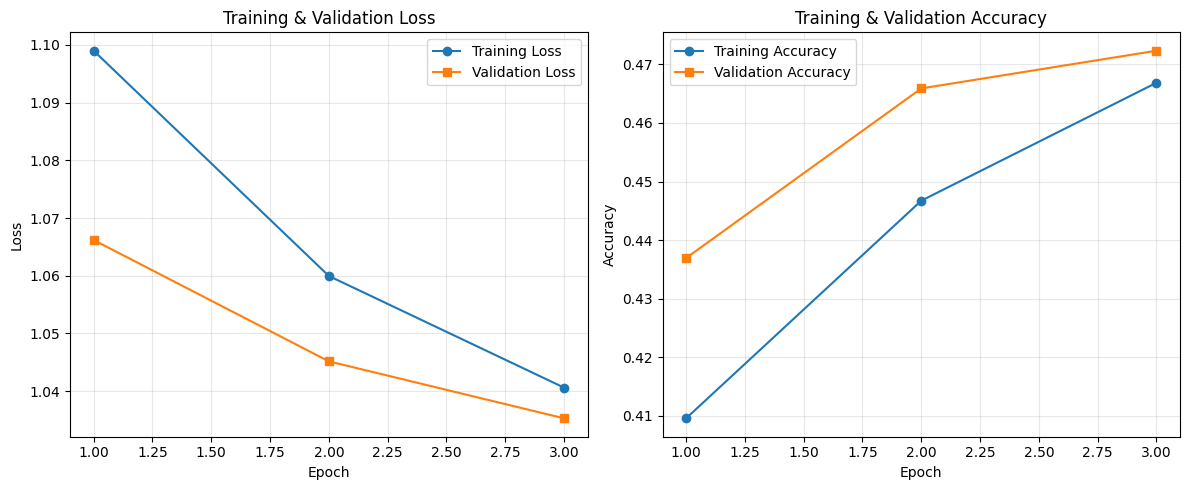

In [36]:
# ==============================================================
# EVALUATION OF TRAINING (Validation Loss & Accuracy) - JAX Backend Fix
# ==============================================================
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

print("--- 검증 데이터셋에 대한 손실(Loss) 및 정확도(Accuracy) 계산 ---")

# --------------------------------------------------------------
# 1) 검증 데이터셋(valid_ds)에 대한 예측 및 손실/정확도 계산
# --------------------------------------------------------------
try:
    # 모델 예측 (JAX array 반환)
    y_pred_probs = model.predict(valid_ds, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # 실제 정답
    y_true = valid_df['class_label'].values

    # JAX 배열 → NumPy 변환
    y_pred_probs_np = np.array(y_pred_probs)
    y_true_jnp = jnp.array(y_true)

    # 손실 계산 (JAX에서 직접 계산)
    from keras.losses import SparseCategoricalCrossentropy
    loss_fn = SparseCategoricalCrossentropy(from_logits=False)
    val_loss = float(loss_fn(y_true_jnp, y_pred_probs_np))

    # 정확도 계산
    val_accuracy = np.mean(y_pred == y_true)

    print("검증 평가 완료.")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

except NameError as e:
    print(f"오류: {e}")
    print("모델(model), valid_ds, valid_df가 정의되어 있는지 확인하세요.")
    raise e
except Exception as e:
    print(f"예상치 못한 오류 발생: {e}")
    raise e

# --------------------------------------------------------------
# 2) 학습 로그에서 Validation Loss/Accuracy 추출 및 시각화
# --------------------------------------------------------------
try:
    if 'history' in globals() and hasattr(history, 'history'):
        hist = history.history

        if 'val_loss' in hist and 'val_accuracy' in hist:
            epochs = range(1, len(hist['val_loss']) + 1)

            plt.figure(figsize=(12, 5))

            # Loss 그래프
            plt.subplot(1, 2, 1)
            plt.plot(epochs, hist['loss'], label='Training Loss', marker='o')
            plt.plot(epochs, hist['val_loss'], label='Validation Loss', marker='s')
            plt.title('Training & Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Accuracy 그래프
            plt.subplot(1, 2, 2)
            plt.plot(epochs, hist['accuracy'], label='Training Accuracy', marker='o')
            plt.plot(epochs, hist['val_accuracy'], label='Validation Accuracy', marker='s')
            plt.title('Training & Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig('val_loss_accuracy.png', dpi=300, bbox_inches='tight')
            print("\n학습 곡선 그래프가 'val_loss_accuracy.png'로 저장되었습니다.")
            plt.show()
        else:
            print("history에 'val_loss' 또는 'val_accuracy' 키가 없습니다.")
    else:
        print("history 객체가 없습니다.")

except Exception as e:
    print(f"학습 로그 시각화 중 오류: {e}")
    raise e